### Import Libraries

In [141]:
# Numeric
import numpy as np
import pandas as pd


# Tools
import os, sys
import re
import string
import csv
import itertools


# # Natural language processing
# import spacy

# from nltk.tokenize import word_tokenize
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.stem import PorterStemmer
# from nltk.corpus import stopwords as sw
# from nltk.stem.snowball import SnowballStemmer


# Preprocessing and Features engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2



# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering



# Classifiers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline



# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

### Some utilities

In [118]:
def print_f1score(scores):
    """Pritn the evaluated f1scores, their mean and standard deviation."""
    print(f"Weighted-f1 for each iteration: {scores}")
    mean_weighted_f1 = scores.mean()
    std_weighted_f1 = scores.std() * 2
    print(f"Weighted-f1 (statistics): {mean_weighted_f1:.3f} (+/- {std_weighted_f1:.3f})")

In [119]:
def write_to_file(filename, labels):
    """Write the evaluated labels to a CSV file."""
    with open(filename, mode='w', encoding='UTF-8') as f:
        fwriter = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        fwriter.writerow(["Id", "Predicted"])
        for Id, label in enumerate(labels):
            fwriter.writerow([Id, label])

### Data exploration

In [120]:
directory = "DSL2122_january_dataset/"
dev_dataset = pd.read_csv(directory + "development.csv")
eval_dataset = pd.read_csv(directory + "evaluation.csv")

print(dev_dataset.iloc[:,0].size)
dev_dataset.head()

224994


,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [121]:
dev_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


In [122]:
print(f"Development dataset size: {dev_dataset['text'].size}")
print(f"Evaluation dataset size: {eval_dataset['text'].size}")

Development dataset size: 224994
Evaluation dataset size: 74999


/tmp/ipykernel_463288/1446544036.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


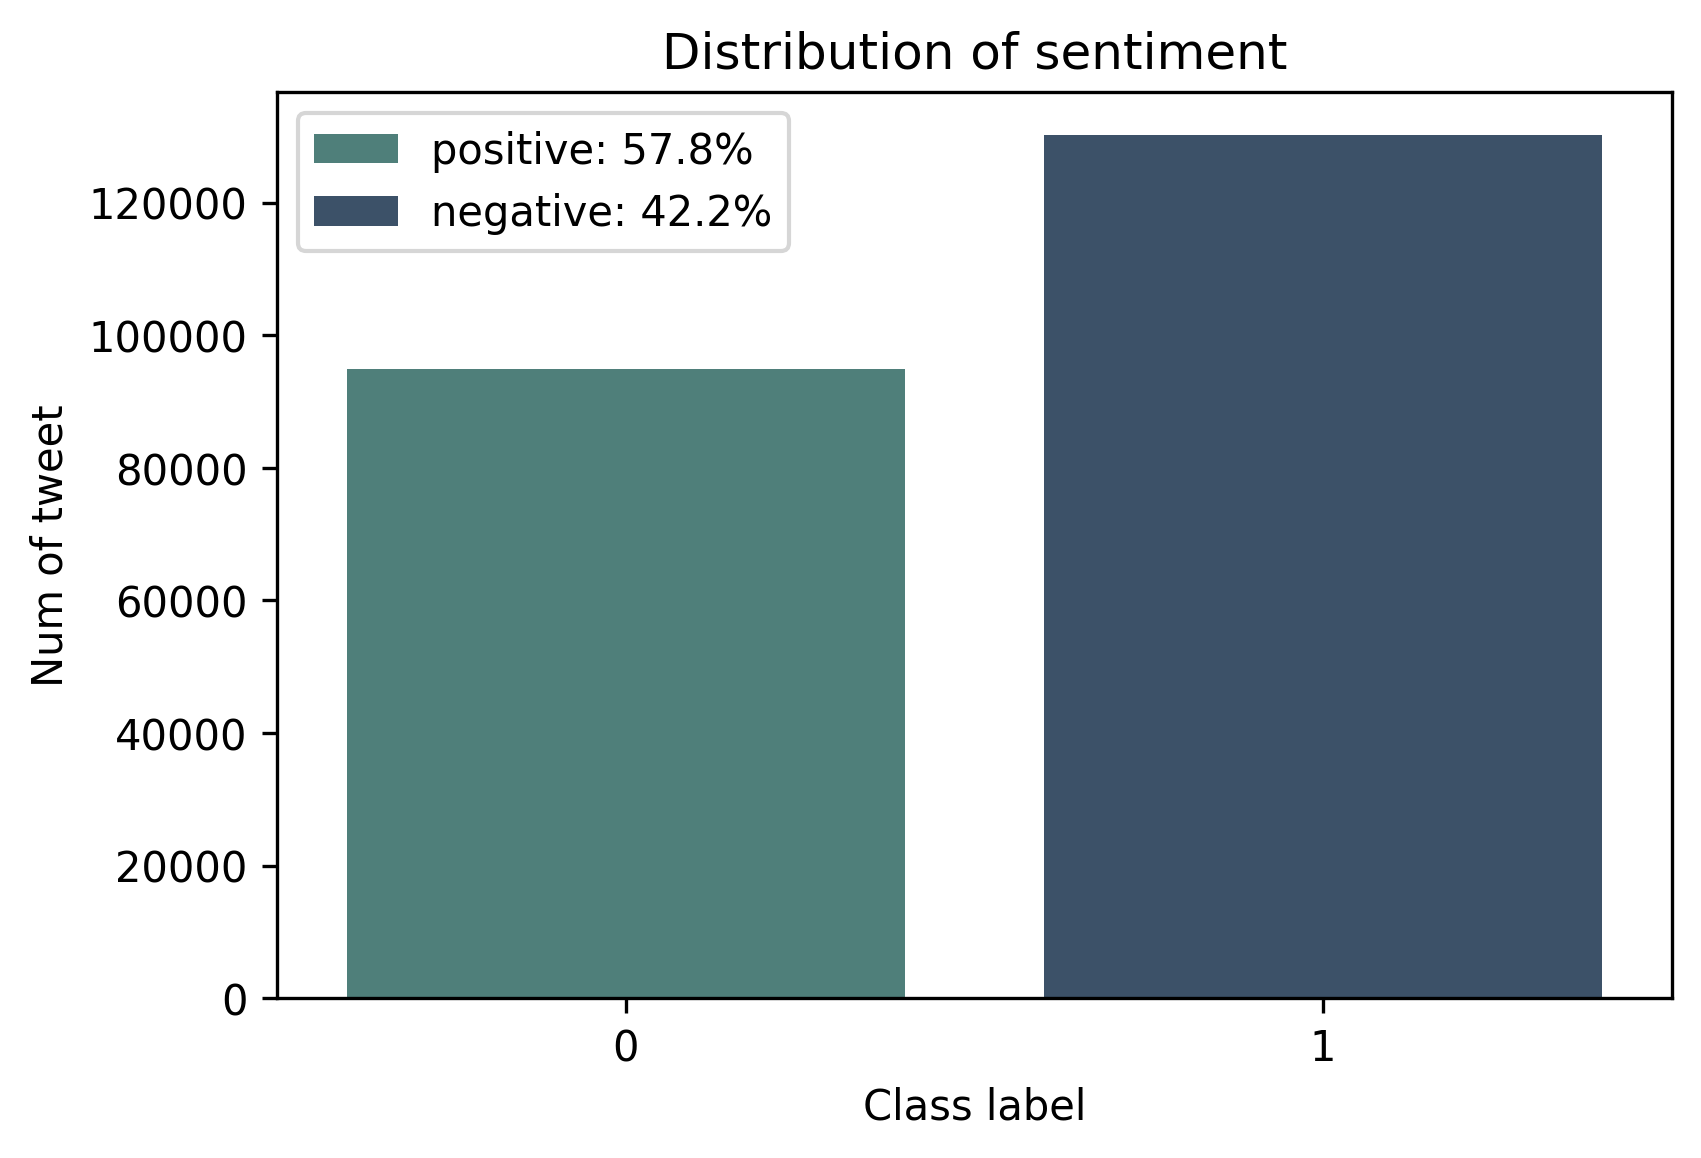

In [123]:

# compute percentages
pos_perc = 100 * dev_dataset[dev_dataset['sentiment'] == 1].size / dev_dataset.size
neg_perc = 100 - pos_perc

fig, ax = plt.subplots(dpi=300)
ax = sns.countplot(x = 'sentiment', data = dev_dataset,
              palette = sns.cubehelix_palette(2, start=.4, rot=-.75, light=.45, dark=.3))
ax.set_ylabel('Num of tweet')
ax.set_xlabel('Class label')
ax.set_title('Distribution of sentiment')
ax.legend(handles=ax.patches, labels=(f'positive: {pos_perc:.1f}%', f'negative: {neg_perc:.1f}%'))
# fig.tight_layout()
fig.show()

### Preprocessing

In [124]:
ds = dev_dataset.copy()
# how many ids are duplicates? around 200
ds.drop_duplicates(['ids'],inplace=True)
print(ds.iloc[:,0].size)

224716


In [125]:
ds = dev_dataset.copy()
# how many flags are there? only one
ds.drop_duplicates(['flag'],inplace=True)
print(ds.iloc[:,0].size)

1


In [126]:
ds = dev_dataset.copy()
# how many user are there? around 10000
ds.drop_duplicates(['user'],inplace=True)
print(ds.iloc[:,0].size)

10647


In [127]:
ds = dev_dataset.copy()
# how many copies of text are there? around 1500
ds.drop_duplicates(['text'],inplace=True)
print(ds.iloc[:,0].size)

223106


In [128]:
#How many nan value there are? 0
ds = dev_dataset.copy()
ds.dropna(subset=['ids', 'user', 'text', 'date', 'flag'])
print("Length of dataframe after NaNs are removed:", len(ds))

Length of dataframe after NaNs are removed: 224994


In [129]:
# ds = dataset.copy()
# ds['ids'].fillna( 0, inplace=True)
# ds['user'].fillna( "", inplace=True)
# ds['text'].fillna( "", inplace=True)
# ds['date'].fillna( "", inplace=True)
# #ds['flag'].fillna( "", inplace=True)

### Tokenizer

### train test split

In [130]:
dev_dataset['text_bis'] = dev_dataset.apply(lambda row: row.text, axis = 1)
df_done = dev_dataset.drop(columns=["flag", "ids", "date"])

eval_dataset['text_bis'] = eval_dataset.apply(lambda row: row.text, axis = 1)
df_eval_done = eval_dataset.drop(columns=["flag", "ids", "date"])

 
feature_names = df_done.columns

print(dev_dataset.head())

X = df_done.drop(columns=["sentiment"])
y = df_done["sentiment"]

X.shape, y.shape

   sentiment         ids                          date      flag  \
0          1  1833972543  Mon May 18 01:08:27 PDT 2009  NO_QUERY   
1          1  1980318193  Sun May 31 06:23:17 PDT 2009  NO_QUERY   
2          1  1994409198  Mon Jun 01 11:52:54 PDT 2009  NO_QUERY   
3          0  1824749377  Sun May 17 02:45:34 PDT 2009  NO_QUERY   
4          0  2001199113  Tue Jun 02 00:08:07 PDT 2009  NO_QUERY   

             user                                               text  \
0       Killandra  @MissBianca76 Yes, talking helps a lot.. going...   
1     IMlisacowan  SUNSHINE. livingg itttt. imma lie on the grass...   
2       yaseminx3           @PleaseBeMine Something for your iphone    
3    no_surprises  @GabrielSaporta couldn't get in to the after p...   
4  Rhi_ShortStack  @bradiewebbstack awww is andy being mean again...   

                                            text_bis  
0  @MissBianca76 Yes, talking helps a lot.. going...  
1  SUNSHINE. livingg itttt. imma lie on the gras

((224994, 3), (224994,))

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=42, shuffle=True)

### Pipeline

In [146]:
model = make_pipeline(
        make_column_transformer(
            (TfidfVectorizer(ngram_range=(1, 4)), "text"),
            (CountVectorizer(ngram_range=(1, 2), binary=True, strip_accents="unicode"), "text_bis"),
            (OneHotEncoder(handle_unknown="ignore"), ["user"]),
            remainder="passthrough"
        ),
        #LogisticRegression(verbose=1, solver='liblinear', random_state=0, C=6, penalty='l2', max_iter=100, n_jobs=-1)
        #MultinomialNB(alpha=0.3),
        LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
        #LinearSVC()
    )
model.fit(X_train, y_train);

# cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# print_f1score(cv_scores)


F1score = f1_score(y_test, model.predict(X_test), average='macro')
print(f"F1score : {F1score}")

F1score : 0.8204387360754894


In [133]:
y_eval = model.predict(df_eval_done)
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("submit-final.csv", index_label="Id", header=["Predicted"])

### ROC curve

[1 0 0 ... 1 1 1]


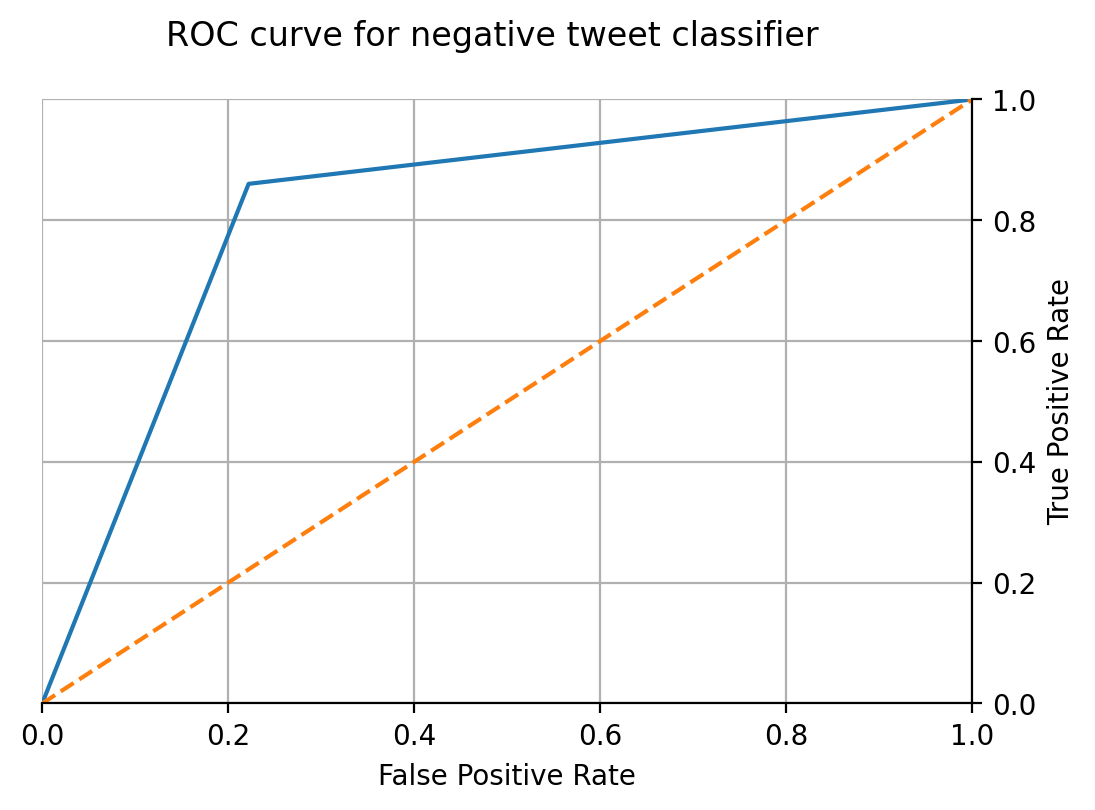

In [148]:
y_score = model.predict(X_test) #[:,1]
print(y_score)

# compute the false positive and true positive rate for the class 'neg'
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig, ax = plt.subplots(dpi=200)
ax.plot(fpr, tpr)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
fig.suptitle('ROC curve for negative tweet classifier')
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.tick_right()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.yaxis.set_label_position("right")
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='dashed')

### Tuning grid search hyperparameter